# Start TF Session

In [1]:
import tensorflow as tf
import numpy as np
np.set_printoptions(suppress=True)

sess = tf.InteractiveSession()

In [7]:
# Imports for visualization
import PIL.Image
from io import StringIO
from IPython.display import clear_output, Image, display
import scipy.ndimage as nd
import scipy.signal
from pathlib import Path

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from typing import List

%matplotlib inline


In [4]:
img_path = Path("..")/"data"/"screenshots"/"ss.png"

# img_file = 'lichess_5.png'

# folder = "chessboards/input_chessboards"
# folder = "chessboards/test_chessboards"

img = PIL.Image.open(img_path)

print( "Loaded %s (%dpx x %dpx)" % \
    (img, img.size[0], img.size[1]) )

Loaded <PIL.PngImagePlugin.PngImageFile image mode=RGB size=974x1047 at 0x1C70867AAC8> (974px x 1047px)


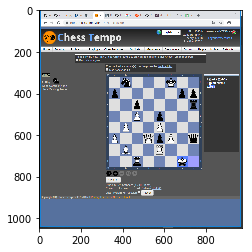

In [5]:


# Resize if image larger than 2k pixels on a side
if img.size[0] > 2000 or img.size[1] > 2000:
    print ("Image too big (%d x %d)" % (img.size[0], img.size[1]))
    new_size = 500.0 # px
    if img.size[0] > img.size[1]:
        # resize by width to new limit
        ratio = new_size / img.size[0]
    else:
        # resize by height
        ratio = new_size / img.size[1]
    print( "Reducing by factor of %.2g" % (1./ratio) )
    img = img.resize(img.size * ratio, PIL.Image.ADAPTIVE)
    print( "New size: (%d x %d)" % (img.size[0], img.size[1]) )

# See original image
#display_array(np.asarray(img), rng=[0,255])

imshow(np.asarray(img))

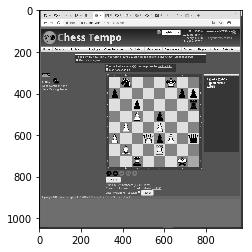

In [6]:
# Convert to grayscale and array
a = np.asarray(img.convert("L"), dtype=np.float32)

imshow(np.asarray(a), cmap='gray')

In [9]:
def make_kernel(a: List[List[float]]):
    """Transform a 2D array into a convolution kernel.
    TF needs the filter to be in 4d so this just appends 2 empty dimensions
    for channel & channel_multiplier
    """
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1, 1])
    return tf.constant(a, dtype=1)


def simple_conv(x, k):
    """A simplified 2D convolution operation"""

    # add extra dimensions for batch # at beginning and channels at end (-1)
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    print(x)
    # data_format: The data format for input. Either "NHWC"
    # input 4-D with shape according to data_format
    # filter 4-D with shape [filter_height, filter_width, in_channels, channel_multiplier].
    y = tf.nn.depthwise_conv2d(input=x,
                               filter=k,

                               strides=[1, 1, 1, 1],
                               padding='SAME',
                               data_format="NHWC"
                               )

    # chop off the batch and channels empty dimensions
    return y[0, :, :, 0]


def gradientx(x):
    """Compute the x gradient of an array"""
    gradient_x = make_kernel([[-1., 0., 1.],
                              [-1., 0., 1.],
                              [-1., 0., 1.]])
    return simple_conv(x, gradient_x)


def gradienty(x):
    """Compute the x gradient of an array"""
    gradient_y = make_kernel([[-1., -1, -1], 
                              [0., 0, 0], 
                              [1., 1, 1]])
    return simple_conv(x, gradient_y)

def corners(x):
    """Find chess square corners in an array"""
    chess_corner = make_kernel([[-1., 0, 1],
                                [0., 0., 0.],
                                [1., 0, -1]])
    return simple_conv(x, chess_corner)


# Following are meant for binary images
def dilate(x, size=3):
    """Dilate"""
    kernel = make_kernel(np.ones([size, size], dtype=np.float32))
    return tf.clip_by_value(simple_conv(x, kernel),
                            np.float32(1),
                            np.float32(2)) - np.float32(1)


def erode(x, size=3):
    """Erode"""
    kernel = make_kernel(np.ones([size, size]))
    return tf.clip_by_value(simple_conv(x, kernel),
                            np.float32(size * size - 1),
                            np.float32(size * size)) - np.float32(size * size - 1)


def opening(x, size=3):
    return dilate(erode(x, size), size)


def closing(x, size=3):
    return erode(dilate(x, size), size)


def skeleton(x, size=3):
    """Skeletonize"""
    return tf.clip_by_value(erode(x) - opening(erode(x)),
                            0.,
                            1.)


In [12]:
# Get our grayscale image matrix
A = tf.Variable(a)

# Get X & Y gradients and subtract opposite gradient
# Strongest response where gradient is unidirectional
# clamp into range 0-1
# Dx = tf.clip_by_value(np.abs(gradientx(A)) - np.abs(gradienty(A)),
#                       0., 1.)
# Dy = tf.clip_by_value(np.abs(gradienty(A)) - np.abs(gradientx(A)),
#                       0., 1.)

Dx = gradientx(A)
Dy = gradienty(A)

# Dxy = np.abs(gradientx(A) * gradienty(A))
# Dc = np.abs(corners(A))

Tensor("ExpandDims_9:0", shape=(1, 1047, 974, 1), dtype=float32)
Tensor("ExpandDims_11:0", shape=(1, 1047, 974, 1), dtype=float32)


In [13]:
# Initialize state to initial conditions
tf.global_variables_initializer().run()

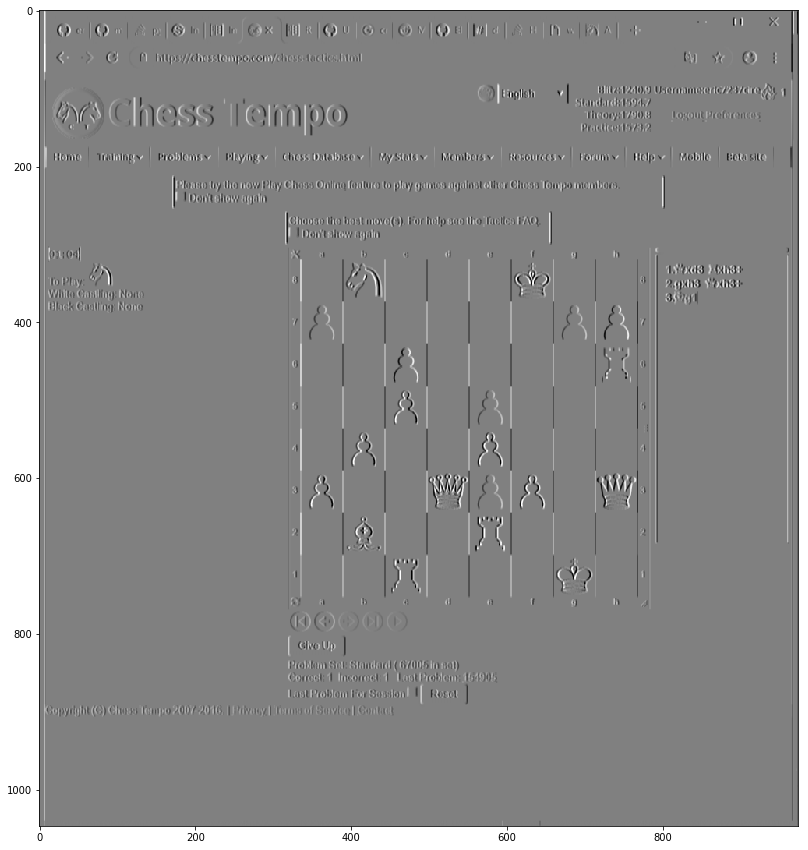

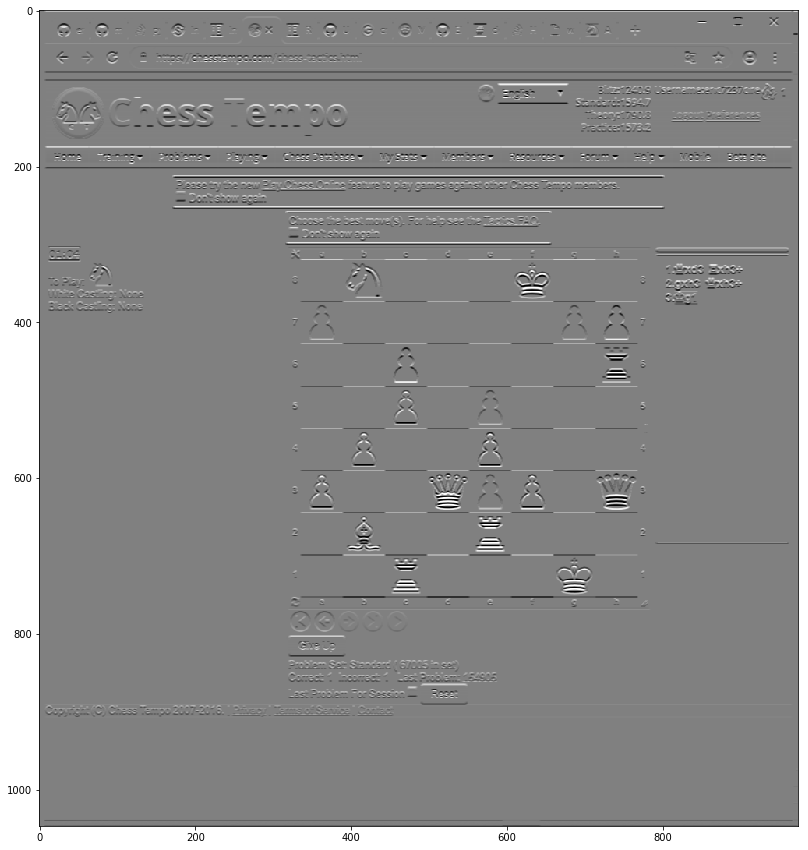

In [14]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)

ax.imshow(Dx.eval(), cmap='gray')

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)
ax.imshow(Dy.eval(), cmap='gray')


In [15]:
Dx_pos = tf.clip_by_value(Dx, 0., 255., name="dx_positive")
Dx_neg = tf.clip_by_value(Dx, -255., 0., name='dx_negative')
Dy_pos = tf.clip_by_value(Dy, 0., 255., name="dy_positive")
Dy_neg = tf.clip_by_value(Dy, -255., 0., name='dy_negative')

hough_Dx = tf.reduce_sum(Dx_pos, 0) * tf.reduce_sum(-Dx_neg, 0) / (a.shape[0]*a.shape[0])
hough_Dy = tf.reduce_sum(Dy_pos, 1) * tf.reduce_sum(-Dy_neg, 1) / (a.shape[1]*a.shape[1])
# Normalized to 0-255*255=65025 range

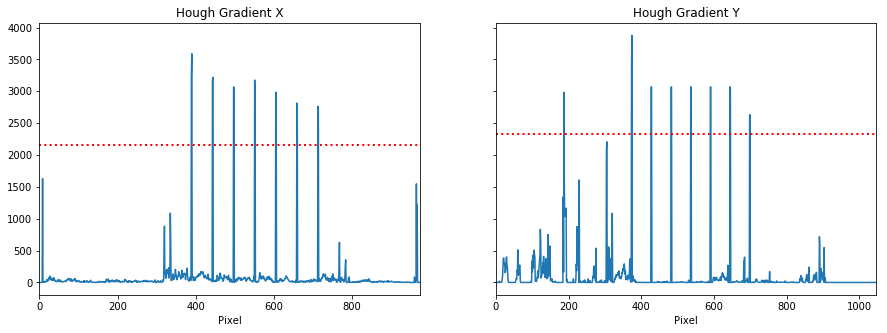

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(15,5))

# Arbitrarily choose half of max value as threshold, since they're such strong responses
hough_Dx_thresh = tf.reduce_max(hough_Dx) * 3 / 5
hough_Dy_thresh = tf.reduce_max(hough_Dy) * 3 /5

ax1.plot(hough_Dx.eval());
ax1.axhline(hough_Dx_thresh.eval(), lw=2,linestyle=':',color='r')
ax1.set_title('Hough Gradient X')
ax1.set_xlabel('Pixel')
ax1.set_xlim(0,a.shape[1])

ax2.plot(hough_Dy.eval())
ax2.axhline(hough_Dy_thresh.eval(), lw=2,linestyle=':',color='r')
ax2.set_title('Hough Gradient Y')
ax2.set_xlim(0,a.shape[0])
ax2.set_xlabel('Pixel');

In [20]:
def checkMatch(lineset):
    """Checks whether there exists 7 lines of consistent increasing order in set of lines"""
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    for line in linediff:
        # Within 5 px of the other (allowing for minor image errors)
        if np.abs(line - x) < 5:
            cnt += 1
        else:
            cnt = 0
            x = line
    return cnt == 5

def pruneLines(lineset):
    """Prunes a set of lines to 7 in consistent increasing order (chessboard)"""
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    start_pos = 0
    for i, line in enumerate(linediff):
        # Within 5 px of the other (allowing for minor image errors)
        if np.abs(line - x) < 5:
            cnt += 1
            if cnt == 5:
                end_pos = i+2
                return lineset[start_pos:end_pos]
        else:
            cnt = 0
            x = line
            print(f"i={i}, x={x}")
            start_pos = i
    return lineset

def skeletonize_1d(arr):
    """return skeletonized 1d array (thin to single value, favor to the right)"""
    _arr = arr.copy() # create a copy of array to modify without destroying original
    # Go forwards
    for i in range(_arr.size-1):
        # Will right-shift if they are the same
        if arr[i] <= _arr[i+1]:
            _arr[i] = 0
    
    # Go reverse
    for i in np.arange(_arr.size-1, 0,-1):
        if _arr[i-1] > _arr[i]:
            _arr[i] = 0
    return _arr

def getChessLines(hdx, hdy, hdx_thresh, hdy_thresh):
    """Returns pixel indices for the 7 internal chess lines in x and y axes"""
    # Blur
    gausswin = scipy.signal.gaussian(21,4)
    gausswin /= np.sum(gausswin)

    # Blur where there is a strong horizontal or vertical line (binarize)
    blur_x = np.convolve(hdx > hdx_thresh, gausswin, mode='same')
    blur_y = np.convolve(hdy > hdy_thresh, gausswin, mode='same')


    skel_x = skeletonize_1d(blur_x)
    skel_y = skeletonize_1d(blur_y)

    # Find points on skeletonized arrays (where returns 1-length tuple)
    lines_x = np.where(skel_x)[0] # vertical lines
    lines_y = np.where(skel_y)[0] # horizontal lines
    
    # Prune inconsistent lines
    lines_x = pruneLines(lines_x)
    lines_y = pruneLines(lines_y)
    
    is_match = len(lines_x) == 7 and len(lines_y) == 7 and checkMatch(lines_x) and checkMatch(lines_y)
    
    return lines_x, lines_y, is_match

# Get chess lines
lines_x, lines_y, is_match = getChessLines(hough_Dx.eval().flatten(), \
                                           hough_Dy.eval().flatten(), \
                                           hough_Dx_thresh.eval(), \
                                           hough_Dy_thresh.eval())

lines_x, lines_y, is_match = getChessLines(hough_Dx.eval().flatten(), \
                                           hough_Dy.eval().flatten(), \
                                           hough_Dx_thresh.eval()*.9, \
                                           hough_Dy_thresh.eval()*.9)

print(f"X {lines_x} {np.diff(lines_x)}")
print(f"Y {lines_y} {np.diff(lines_y)}")
if is_match:
    print ("Chessboard found")
else:
    print ("Couldn't find Chessboard")

i=0, x=54
i=0, x=187
i=1, x=54
i=0, x=54
i=0, x=118
i=1, x=69
i=2, x=54
X [390 444 498 552 606 660 714] [54 54 54 54 54 54]
Y [374 428 483 537 591 645 699] [54 55 54 54 54 54]
Chessboard found


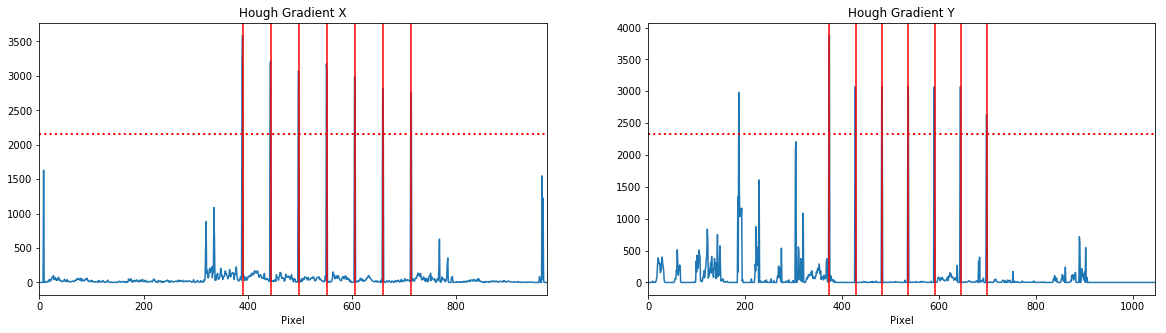

In [21]:
# Plot blurred 1d hough arrays and skeletonized versions
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

ax1.plot(hough_Dx.eval());
ax1.axhline(hough_Dx_thresh.eval(), lw=2,linestyle=':',color='r')
ax1.set_title('Hough Gradient X')
ax1.set_xlabel('Pixel')
ax1.set_xlim(0,a.shape[1])

ax2.plot(hough_Dy.eval())
ax2.axhline(hough_Dy_thresh.eval(), lw=2,linestyle=':',color='r')
ax2.set_title('Hough Gradient Y')
ax2.set_xlim(0,a.shape[0])
ax2.set_xlabel('Pixel');

# Plot lines for where peaks where found
if len(lines_x < 20):
    for hx in lines_x:
        ax1.axvline(hx,color='r')
if len(lines_y < 20):
    for hy in lines_y:
        ax2.axvline(hy,color='r')

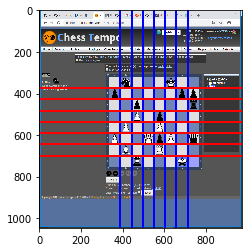

In [22]:
plt.imshow(img)
for hx in lines_x:
    plt.axvline(hx, color='b', lw=2)

for hy in lines_y:
    plt.axhline(hy, color='r', lw=2)

# Hello
